In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

## Set up sky grid and information ##

In [2]:
nside = 128
# healpix indexes
hpid = np.arange(0, hp.nside2npix(nside))
# Ra/dec in degrees
ra, dec = hp.pix2ang(nside, hpid, lonlat=True)

In [3]:
# Get ecliptic and galactic coordinates
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
eclip_lat = coord.barycentrictrueecliptic.lat.deg
eclip_lon = coord.barycentrictrueecliptic.lon.deg
gal_lon = coord.galactic.l.deg
gal_lat = coord.galactic.b.deg

In [4]:
# Dustmap from sims_maps  - this is basically just a data directory
# The dustmap data is downloadable from https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/maps_may_2021.tgz
# (then just set SIMS_MAPS_DIR to where you downloaded it, after untarring the file)
def get_dustmap(nside=None):
    if nside is None:
        nside = set_default_nside()
    ebvDataDir = os.getenv('SIMS_MAPS_DIR')
    if ebvDataDir is None:
        ebvDataDir = os.path.join(os.getenv('HOME'), 'rubin_sim_data', 'maps')
    filename = 'DustMaps/dust_nside_%i.npz' % nside
    dustmap = np.load(os.path.join(ebvDataDir, filename))['ebvMap']
    return dustmap

In [5]:
# Get the dust extinction values at each healpix
dustmap = get_dustmap(nside)

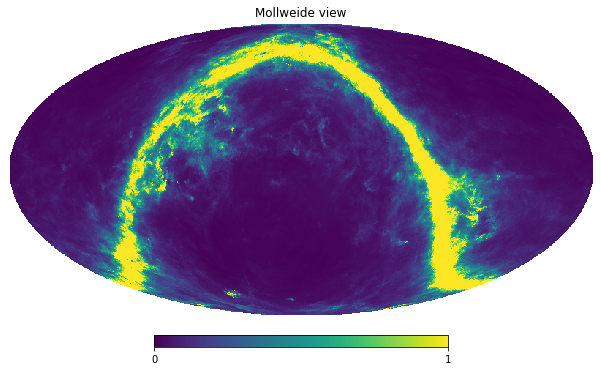

In [43]:
hp.mollview(dustmap, min=0, max=1, norm=None)

## Estimate of survey time requirements ##

In [7]:
# How much survey time .. approximately .. is it likely to take to cover this area? 
# We can use a rough scaling derived from 
# https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb

# x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.77)  == constant (~1)

def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    defaults = {'survey_frac': 0.77, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']

Text(0, 0.5, 'Survey fraction')

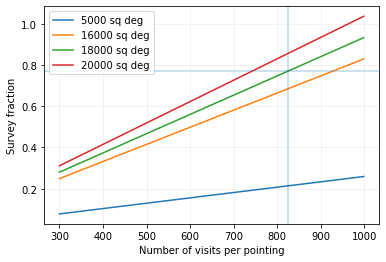

In [8]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.axhline(0.77, alpha=0.3)
plt.axvline(825, alpha=0.3)
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

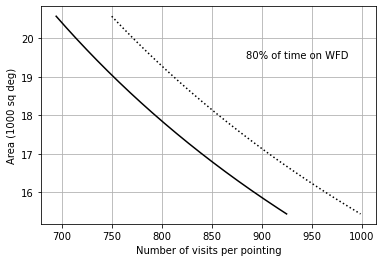

In [9]:
nvis=np.arange(750, 1000)
plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.8)/1000, 'k:')
plt.plot(nvis/1.08, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.8)/1000, 'k-')
plt.figtext(s='80% of time on WFD', x=0.6, y=0.7)
plt.xlabel('Number of visits per pointing')
plt.ylabel('Area (1000 sq deg)')
plt.grid()
# The solid line = the scaling function / 1.08 .. which both is about the level of variation between 'Minimum'
# number of visits per pointing and "Median" nvisits/pointing (in most simulations) AND a not-unreasonable amount
# of number of visits per pointing to hold as 'contingency'
# .. in other words, plan for the solid line, hope for the dashed line (?)

In [10]:
scalingfunc(nvisits_per_pointing=967, area=15300)

0.7671533333333334

## Low-dust extinction extragalactic

In [11]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
# These dec and dust limits are used to define the other survey areas as well. 
dust_limit = 0.2
dec_max = 8
dec_min = -67

exwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap < dust_limit), 1, 0)

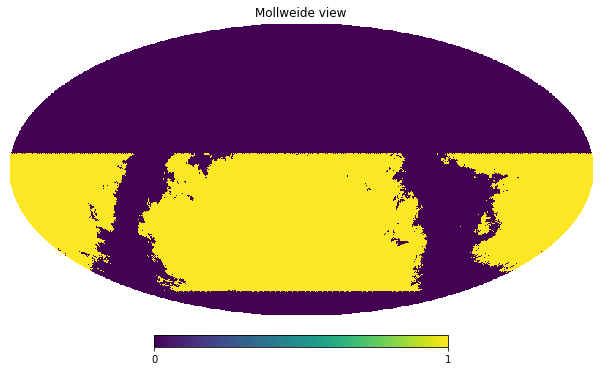

In [42]:
# Where is this on the sky?
hp.mollview(exwfd, max=1, norm=None)

In [13]:
# how much area is covered? 
exgal_area = exwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in extragalactic wfd {exgal_area}')

Area in extragalactic wfd 16581.295078203115


In [14]:
# survey time required?
# ... looking at DESC FOM for footprint_8 vs. baseline_v1.5 -- 
# there seems to be a preference for MORE visits > more area .. so increase nvisits/pointing. 825 is not enough.
# extragalactic area in baseline_v1.5 corresponded to about 77% of total survey
# But this also means we don't have to hold contingency (above 825 for SRD) here anymore ..
nvis_exgal = 900
t_exgal = scalingfunc(nvisits_per_pointing=nvis_exgal, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD area {exgal_area: .2f}, at {nvis_exgal} "\
      f"visits per pointing is {t_exgal: .3f}")

# But we have a desire to keep the number of visits per pointing higher to keep reserve in 'wfd' labelled area
#nvis_exgal = int(825 * 1.08)
#t_exgal = scalingfunc(nvisits_per_pointing=nvis_exgal, area=exgal_area)
#print(f"Survey fraction required for extragalactic WFD with {nvis_exgal} visits per pointing {t_exgal}")

Survey fraction required for extragalactic WFD area  16581.30, at 900 visits per pointing is  0.774


## Galactic Plane ##

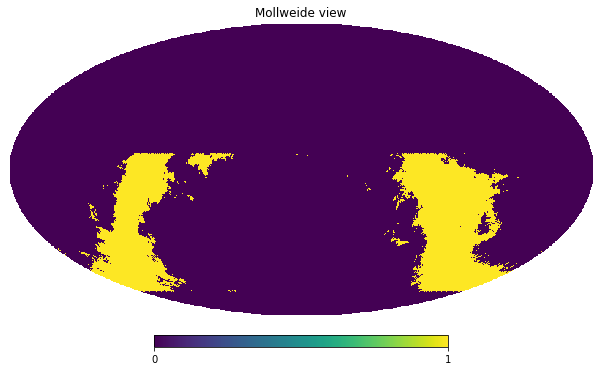

In [15]:
# Start with defining galactic plane zone as the entirety of the plane which was excluded by dust extinction above
galwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap > dust_limit), 1, 0)
hp.mollview(galwfd, max=1, norm=None)

In [16]:
# how much area is covered? 
gp_area = galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in large galactic wfd {gp_area}')

Area in large galactic wfd 5252.92910196539


In [17]:
# Time required for full plane?
nvis = 825
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for full galactic WFD {gp_area: .2f}, at {nvis} visits per pointing {t_gp: .3f}")
nvis = int(825*1.08)
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for full galactic WFD {gp_area: .2f} with {nvis} visits per pointing {t_gp: .3f}")

Survey fraction required for full galactic WFD  5252.93, at 825 visits per pointing  0.225
Survey fraction required for full galactic WFD  5252.93 with 891 visits per pointing  0.243


So, this (with the extragalactic area) requires too much time -- we couldn't do DDFs or the NES or MC's or ... 

But the galactic plane has options - one being separating the plane into 'bulge' and 'the rest' or 'bulge', 'bridge' (a region at the opposite RA as the bulge) and 'the rest'.

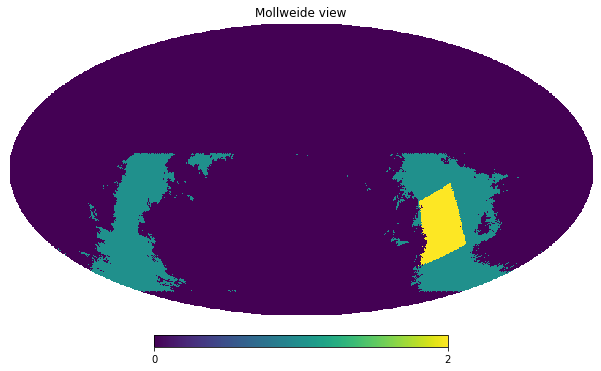

In [18]:
# Or if we reduce the number of visits to 300 over most of the plane and leave the bulge at 825
bulge_lon_span = 20
bulge_lat_span = 10
bulge = np.where(galwfd & 
                 (((gal_lon > (360-bulge_lon_span)) | (gal_lon < bulge_lon_span)) 
                  & (np.abs(gal_lat) < bulge_lat_span)), 1, 0)
gp_nobulge = galwfd - bulge
hp.mollview(bulge * 2 + gp_nobulge, min=0, max=2, norm=None)

In [19]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_area = gp_nobulge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {bulge_area: .2f} and non-bulge plane {gp_nobulge_area: .2f}')
print(f'Area in bulge plus exgal (for SRD consideration) {bulge_area + exgal_area : .2f}')

Area in bulge  764.81 and non-bulge plane  4488.12
Area in bulge plus exgal (for SRD consideration)  17346.10


In [20]:
# Hold SRD contingency in bulge area as well as exgal .. (min area + min nvisits)
nvis_bulge = int(825 * 1.08)   
nvis_nobulge = 280
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_nobulge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_area)
print(f"Survey fraction required to cover the bulge to {nvis_bulge} visits per pointing\n",
      f" and the remainder of the plane to {nvis_nobulge} visits per pointing",
      f"{t_bulge + t_nobulge : .3f}")

Survey fraction required to cover the bulge to 891 visits per pointing
  and the remainder of the plane to 280 visits per pointing  0.100


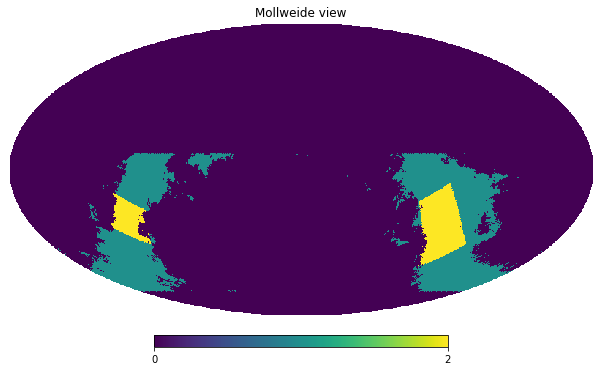

In [21]:
# And similar, but adding additional coverage at the 'bridge'
outer_bridge_l = 240
outer_bridge_lon_span = 10
outer_bridge_lat_span = 13
bridge = np.where(galwfd & 
                  (((gal_lon < (outer_bridge_l + outer_bridge_lon_span))
                    & (gal_lon > (outer_bridge_l-outer_bridge_lon_span))
                    & (np.abs(gal_lat) < outer_bridge_lat_span))), 1, 0)
gp_nobulge_nobridge = galwfd - bulge - bridge
hp.mollview(bulge*2 + bridge*2 + gp_nobulge, max=2, norm=None)

In [22]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
bridge_area = bridge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_nobridge_area = gp_nobulge_nobridge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {bulge_area: .2f}, bridge {bridge_area: .2f}, and non-bulge plane {gp_nobulge_nobridge_area: .2f}')
print(f'Area in bulge plus bridge plus exgal (for SRD consideration) {bulge_area + bridge_area + exgal_area : .2f}')

Area in bulge  764.81, bridge  299.84, and non-bulge plane  4188.29
Area in bulge plus bridge plus exgal (for SRD consideration)  17645.94


In [23]:
nvis_bulge = int(825 * 1.08)
nvis_bridge = int(825 * 1.08)
nvis_nobulge = 280
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_bridge = scalingfunc(nvisits_per_pointing=nvis_bridge, area=bridge_area)
t_nobulge_nobridge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_nobridge_area)
print(f"Survey fraction required to cover the bulge {bulge_area:.2f} to {nvis_bulge} visits per pointing\n",
      f" the bridge {bridge_area:.2f} to {nvis_bridge} visits per pointing\n",
      f" and the remainder of the plane {gp_nobulge_nobridge_area:.2f} to {nvis_nobulge} visits per pointing: ",
      f"{t_bulge + t_bridge + t_nobulge_nobridge: .3f}")

Survey fraction required to cover the bulge 764.81 to 891 visits per pointing
  the bridge 299.84 to 891 visits per pointing
  and the remainder of the plane 4188.29 to 280 visits per pointing:   0.110


In [24]:
t_gal = t_bulge + t_bridge + t_nobulge_nobridge

## Ecliptic coverage ##

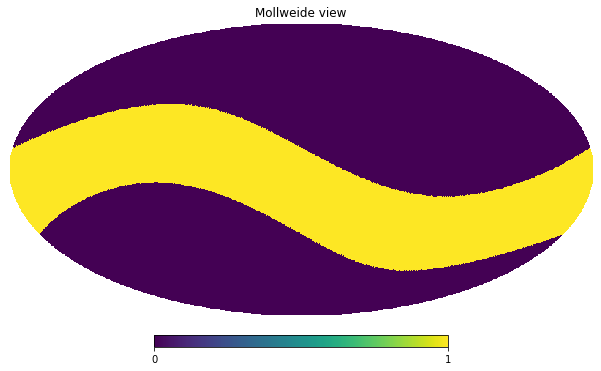

In [25]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -30
eclat_max = 10. 

ecplane = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max), 1, 0)

hp.mollview(ecplane, max=1, norm=None)

In [26]:
# how much area is covered? 
ecplane_area = ecplane.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {ecplane_area}')

nvis_nes=400
t_ecliptic = scalingfunc(nvisits_per_pointing=nvis_nes, area=ecplane_area)
print(f"Survey fraction required for ecliptic plane, at {nvis_nes} visits per pointing {t_ecliptic: .3f}")

Area in ecliptic plane total 13897.0241774065
Survey fraction required for ecliptic plane, at 400 visits per pointing  0.288


Which again, is obviously more time than is possible. But also - the ecliptic plane overlaps much of the rest of the survey (although there may still be different requirements for cadence). 

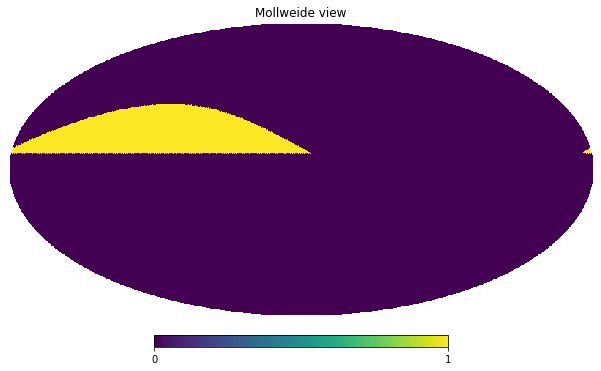

In [27]:
# So let's look at just the northern ecliptic spur part - where it's not potentially covered by other survey visits
nes = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max) & (dec > dec_max), 1, 0)
hp.mollview(nes, max=1, norm=None)

In [28]:
# how much area is covered? 
nes_area = nes.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {nes_area}')

nvis_nes=400
t_nes = scalingfunc(nvisits_per_pointing=nvis_nes, area=nes_area)
print(f"Survey fraction required for north ecliptic spur {nes_area: .2f}, at {nvis_nes} visits per pointing {t_nes:.3f}")

Area in ecliptic plane total 3030.269706034918
Survey fraction required for north ecliptic spur  3030.27, at 400 visits per pointing 0.063


## Magellanic Clouds ##

In [29]:
import numbers
def _angularSeparation(long1, lat1, long2, lat2):
    """
    Angular separation between two points in radians
    Parameters
    ----------
    long1 is the first longitudinal coordinate in radians
    lat1 is the first latitudinal coordinate in radians
    long2 is the second longitudinal coordinate in radians
    lat2 is the second latitudinal coordinate in radians
    Returns
    -------
    The angular separation between the two points in radians
    Calculated based on the haversine formula
    From http://en.wikipedia.org/wiki/Haversine_formula
    """
    t1 = np.sin(lat2/2.0 - lat1/2.0)**2
    t2 = np.cos(lat1)*np.cos(lat2)*np.sin(long2/2.0 - long1/2.0)**2
    _sum = t1 + t2

    if isinstance(_sum, numbers.Number):
        if _sum<0.0:
            _sum = 0.0
    else:
        _sum = np.where(_sum<0.0, 0.0, _sum)

    return 2.0*np.arcsin(np.sqrt(_sum))

In [30]:
def magellanic_clouds_healpixels(nside, lmc_radius=10, smc_radius=5):
    """
    Define the Magellanic clouds region. Return a healpix map with cloud pixels as 1.
    """
    # healpix indexes
    hpid = np.arange(0, hp.nside2npix(nside))
    # Ra/dec in degrees
    ra, dec = hp.pix2ang(nside, hpid, lonlat=True)
    ra = np.radians(ra)
    dec = np.radians(dec)
    result = np.zeros(hp.nside2npix(nside))

    lmc_ra = np.radians(80.893860)
    lmc_dec = np.radians(-69.756126)
    lmc_radius = np.radians(lmc_radius)

    smc_ra = np.radians(13.186588)
    smc_dec = np.radians(-72.828599)
    smc_radius = np.radians(smc_radius)

    dist_to_lmc = _angularSeparation(lmc_ra, lmc_dec, ra, dec)
    lmc_pix = np.where(dist_to_lmc < lmc_radius)
    result[lmc_pix] = 1

    dist_to_smc = _angularSeparation(smc_ra, smc_dec, ra, dec)
    smc_pix = np.where(dist_to_smc < smc_radius)
    result[smc_pix] = 1
    return result

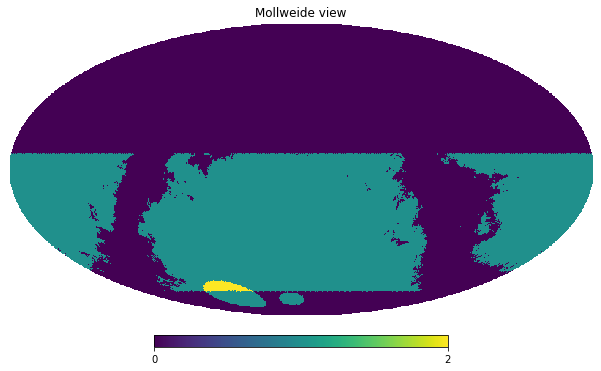

In [31]:
# So this shows us the magellanic clouds, but they do overlap with over survey areas
mag_clouds = magellanic_clouds_healpixels(nside)
hp.mollview(mag_clouds + exwfd, max=2, norm=None)

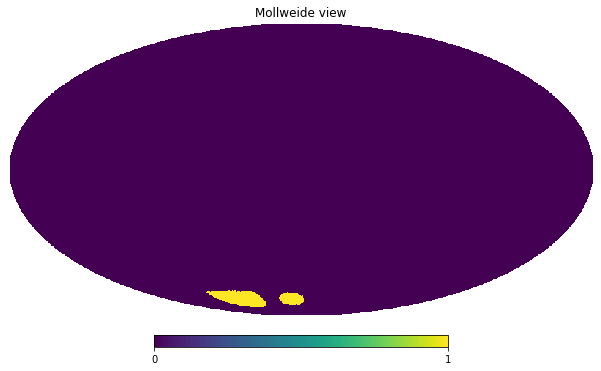

In [32]:
# If we want to just include the area outside the extraglactic WFD - assume WFD is good enough
mag_clouds = np.where((mag_clouds==1) & (exwfd==0), 1, 0)
hp.mollview(mag_clouds, max=1, norm=None)

In [33]:
# how much area is covered? 
mag_area = mag_clouds.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in magellanic clouds total {mag_area: .2f}')

nvis_mag=825  # no need for contingency here
t_mag = scalingfunc(nvisits_per_pointing=nvis_mag, area=mag_area)
print(f"Survey fraction required for magellanic clouds {mag_area:.2f}, at {nvis_mag} visits per pointing {t_mag: .3f}")

Area in magellanic clouds total  278.23
Survey fraction required for magellanic clouds 278.23, at 825 visits per pointing  0.012


## Southern Celestial Pole ##

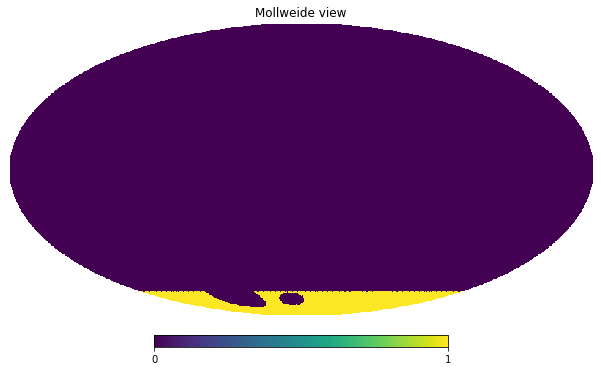

In [34]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
scp = np.where((dec < dec_min) & (mag_clouds == 0), 1, 0)
hp.mollview(scp)

In [35]:
scp_area = scp.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in southern celestial pole {scp_area}')

nvis_scp = 180 # 6 filters * 3 visits per year * 10 years
t_scp = scalingfunc(nvisits_per_pointing=nvis_scp, area=scp_area)
print(f"Survey fraction required for south celestial pole {scp_area: .2f}, at {nvis_scp} visits per pointing {t_scp: .3f}")

Area in southern celestial pole 1364.0619968794488
Survey fraction required for south celestial pole  1364.06, at 180 visits per pointing  0.013


## Total ##

In [36]:
# We need at least 5% of the time for DDFs - 1% per pointing
t_ddf = 0.05
ddf_area = t_ddf / .01 * 9.6
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03

In [37]:
# Modify this as needed .. for example, if changing galactic plane structure
surveyfootprint = (nvis_exgal * exwfd 
                   + nvis_bulge * bulge + nvis_bridge * bridge
                   + nvis_nobulge * gp_nobulge_nobridge
                   + nvis_mag * mag_clouds
                   + nvis_nes * nes 
                   + nvis_scp * scp)

In [38]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
goal_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= int(825 * 1.08))[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least 825 visits per pointing {goal_srd}")
print(f"Area covered to at least 825 visits PLUS 8% reserve {res_srd}")

Area covered to at least 825 visits per pointing 17924.16491054098
Area covered to at least 825 visits PLUS 8% reserve 17649.086418323022


In [39]:
t_total = t_exgal + t_gal + t_nes + t_mag + t_scp
t_total += t_ddf + t_mini
area_total = exgal_area + bulge_area + bridge_area + nes_area + mag_area + scp_area + ddf_area

pd.DataFrame([[exgal_area, t_exgal, nvis_exgal], 
              [bulge_area + bridge_area, t_bulge + t_bridge, nvis_bulge],
              [gp_nobulge_nobridge_area, t_nobulge_nobridge, nvis_nobulge],
              [nes_area, t_nes, nvis_nes], 
              [mag_area, t_mag, nvis_mag], 
              [scp_area, t_scp, nvis_scp], 
              [ddf_area, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan],
              [area_total, t_total, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "Bulge+Bridge", "Galactic-Other", "NES", "MCs", "SCP", "DDF", "Mini", "Total"])

,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,16581.295078,0.773794,900.0
Bulge+Bridge,1064.643989,0.049187,891.0
Galactic-Other,4188.285113,0.060808,280.0
NES,3030.269706,0.062850,400.0
MCs,278.225843,0.011902,825.0
SCP,1364.061997,0.012731,180.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.030000,NaN
Total,22366.496613,1.051271,NaN


Text(0.5, 1.0, 'Survey footprint (105.1%)')

<Figure size 720x576 with 0 Axes>

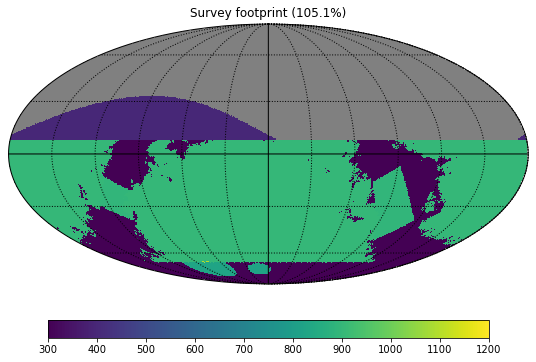

In [44]:
fig = plt.figure(figsize=(10, 8))
surveyfootprint = np.where(surveyfootprint == 0, hp.UNSEEN, surveyfootprint)
#hp.mollview(surveyfootprint, min=0, max=1000, norm=None, cbar=False)
hp.mollview(surveyfootprint, min=300, max=1200, norm=None, cmap="viridis", cbar=False)
# Add colorbar / extras
hp.graticule(dpar=30, dmer=30, verbose=False)
im = plt.gca().get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                  extendrect=True)
plt.title(f'Survey footprint ({t_total*100:.1f}%)')


In [41]:
print(f"Total time required {t_total: .3f}")

Total time required  1.051
